In [65]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
import json
acc_score = od()

In [66]:
def get_entropy_from_culling_factor(c):
    S = od()
    for E in range(-len(c), 1):
        if E in c:
            S[E] = np.log(c[E])
        for E1 in c:
            if (E1 > E):
                S[E] += np.log(1 - c[E1])
    return S

def get_entropy_from_culling_factor_with_heat(c):
    S = od()
    for E in range(-len(c) + 1, 1):
        if E in c:
            S[E + 2] = np.log(c[E])
        for E1 in c:
            if (E1 < E):
                S[E + 2] += np.log(1 - c[E1])
    return S

In [67]:
def read_files(parameters):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = "./datasets/2DHexPotts{}_q{}_N{}_R{}_nSteps{}_run{}X.txt".format("Heating" * heat, q, N, R, nSteps, seed)
    culling_factor = od()
    print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c

    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat(culling_factor)
    
    return parameters

In [109]:
heat, cool = {
    "q": 4,
    "L": 16,
    "R" : 524288,
    "nSteps" : 50,
    "seed" : 0,
    "heat": True
}, {
    "q": 4,
    "L": 16,
    "R" : 524288,
    "nSteps" : 50,
    "seed" : 0,
    "heat": False
}

for parameters in [heat, cool]:
    parameters = read_files(parameters)

256 524288 50 True
256 524288 50 False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [110]:
def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} & {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in range(- 3 * heat["L"] ** 2 // 2, 1):
        if E < max(cniv):
            result[E] = cool["S"][E]
        elif E >= max(cniv):
            result[E] = heat["S"][E] - shift    
    return result

In [111]:
stitched = stitch_S(heat, cool)

In [112]:
def analytical_S(q, L, cool):
    N = L * L
    E0 = - 3 * N // 2
    result = {
        E0: np.log(q),
        E0 + 3: np.log(q) + np.log(N) + np.log(q - 1),
        E0 + 4: np.log(q) + np.log(N) + np.log(q - 1) + np.log(3 / 2),
        E0 + 5: np.log(6 * N * (q - 1) + N * q * (q - 1) * (N - 3)),
        E0 + 6: np.log(6 * N * (q - 1) * (q - 2) * q + N * q * (q - 1) * (N - 3))
    }
    for E in result:
        result[E] += cool["S"][E0] - np.log(q)
    return result

In [113]:
analytical = analytical_S(cool["q"], cool["L"], cool)

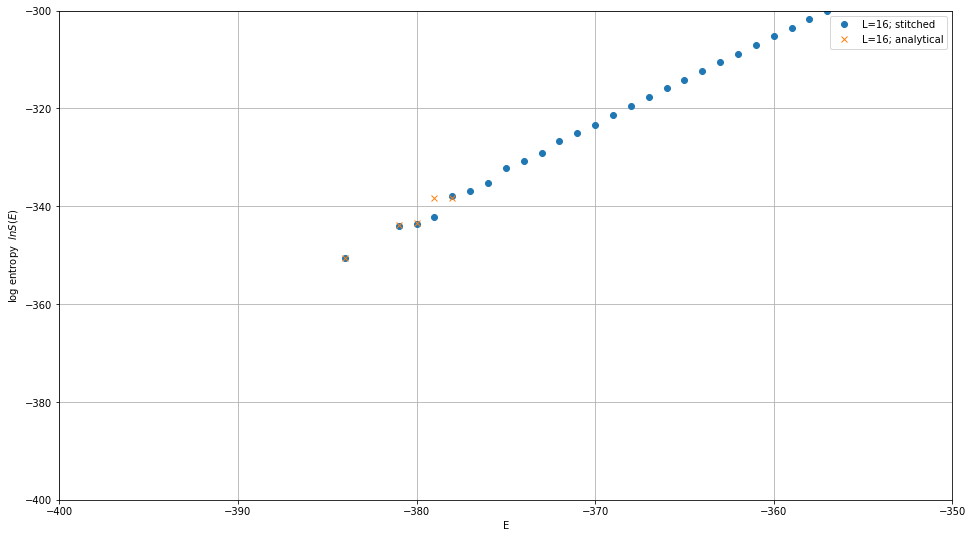

In [121]:
plt.figure(figsize=(16, 9))

plt.plot([E for E in stitched], [S + 3 for E, S in stitched.items()], 'o', label="L={}; stitched".format(heat["L"]))
#plt.plot([E for E in heat["S"]], [S + 1 for E, S in heat["S"].items()], 'o', label="L={}; heating".format(heat["L"]))
#plt.plot([E for E in cool["S"]], [S for E, S in cool["S"].items()], 'o', label="L={}; cooling".format(cool["L"]))

plt.plot([E for E in analytical], [S + 3 for E, S in analytical.items()], 'o', label="L={}; analytical".format(heat["L"]),
        marker = "x")

plt.ylabel("log entropy  $ln S(E)$")
plt.xlabel("E")
plt.xlim([-400, -350])
plt.ylim([-400, -300])
plt.legend()
plt.grid()

R movement